Saving btc_200d_indicators (1).xlsx to btc_200d_indicators (1) (4).xlsx
--- Timeframe: 1H ---
        Pearson_r
RSI      0.252341
EMA50   -0.031183
EMA100  -0.030772
Mom_5    0.444124
Vol_6    0.011897
OLS R-squared: 0.198
Logistic AUC: 0.671



<ipython-input-5-5e861faa18af>:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


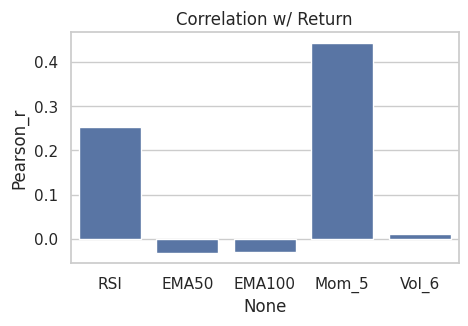

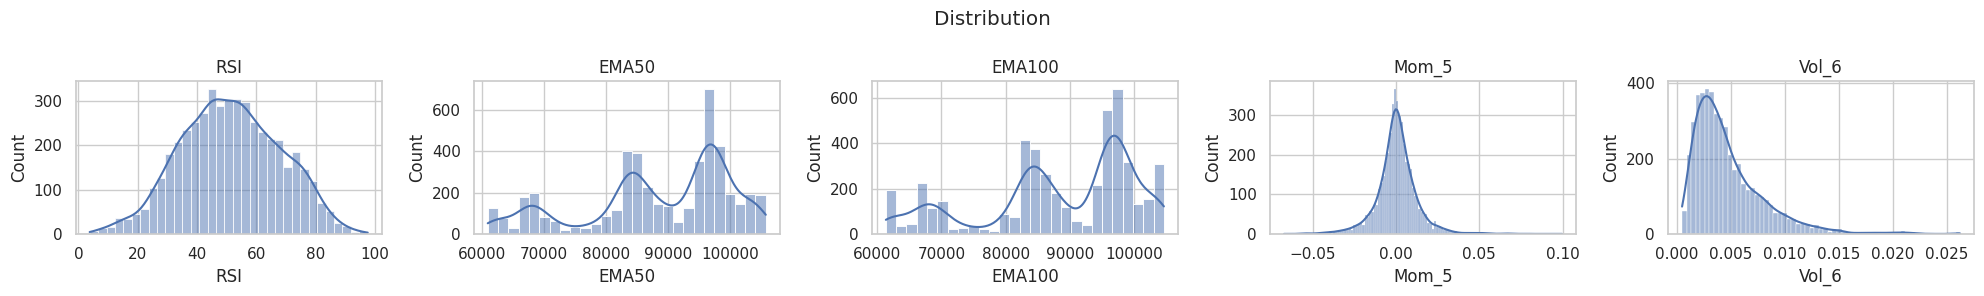

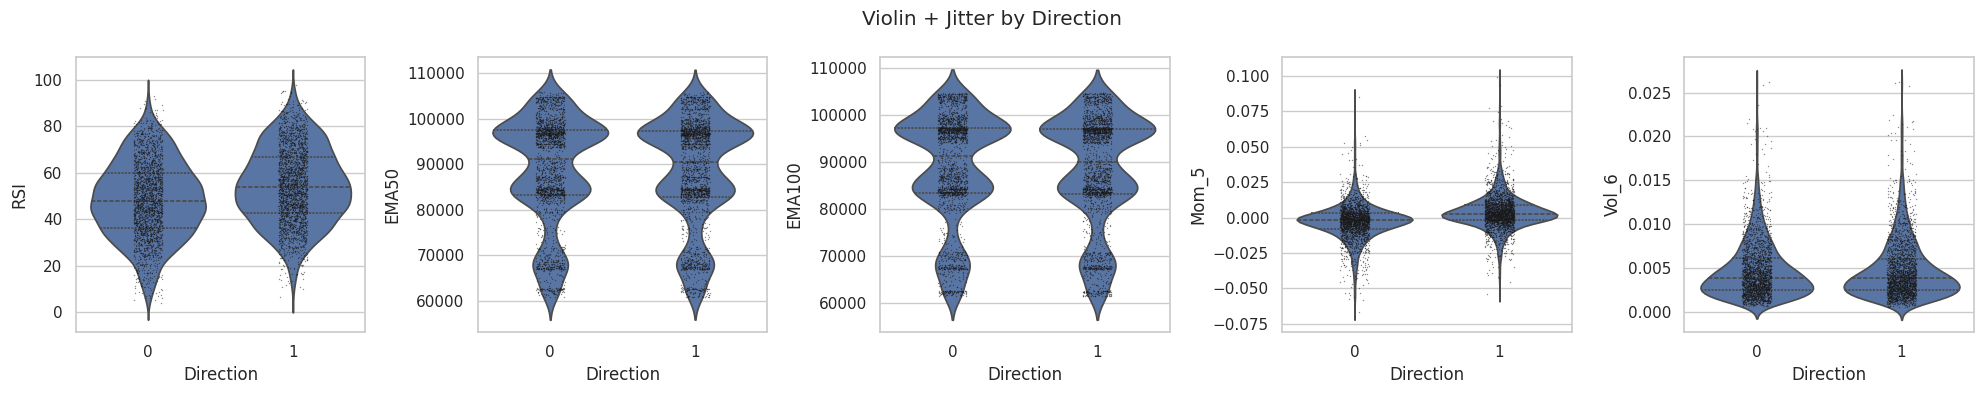

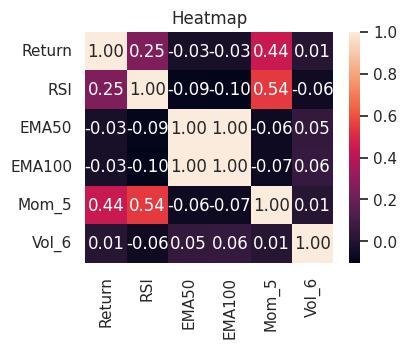

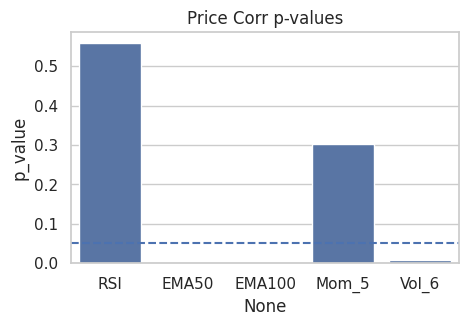

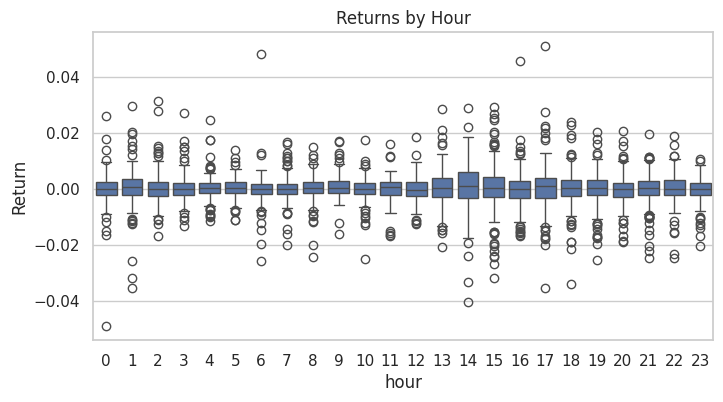

<Figure size 800x300 with 0 Axes>

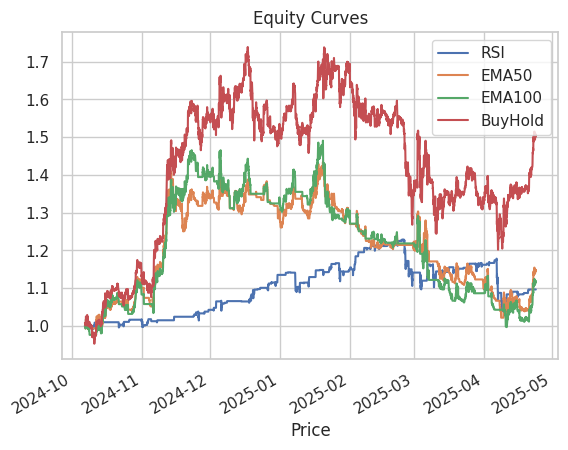

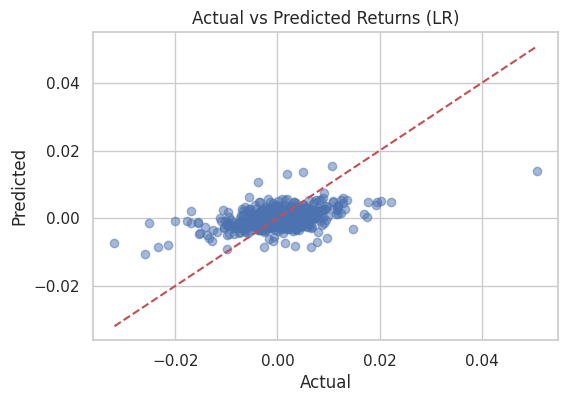

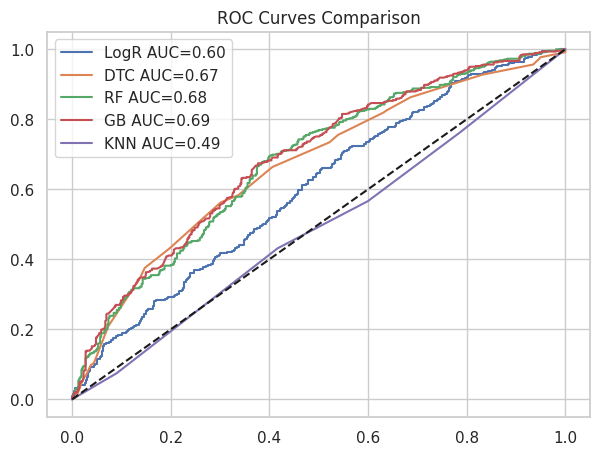

,Model,RMSE,MAE,Accuracy,AUC
0,LR,0.004684,0.003212,nan,nan
1,LogR,nan,nan,0.569488,0.601428
2,DTC,nan,nan,0.607106,0.667347
3,RF,nan,nan,0.645768,0.679124
4,GB,nan,nan,0.639498,0.686290
5,KNN,nan,nan,0.483804,0.489439


--- Timeframe: 2H ---
        Pearson_r
RSI      0.234423
EMA50   -0.041089
EMA100  -0.040736
Mom_5    0.448612
Vol_6    0.040418
OLS R-squared: 0.202
Logistic AUC: 0.672



<ipython-input-5-5e861faa18af>:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


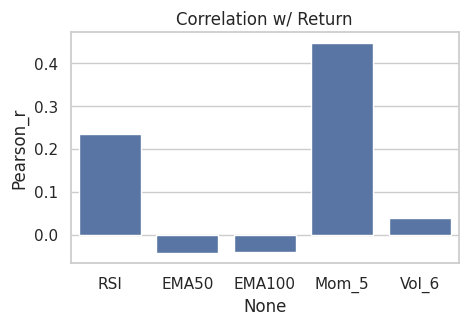

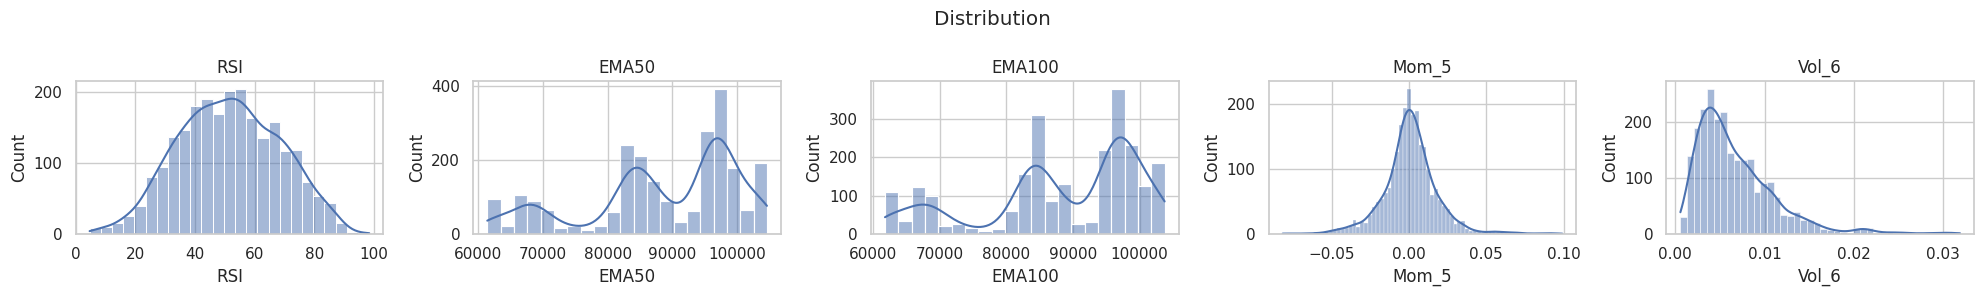

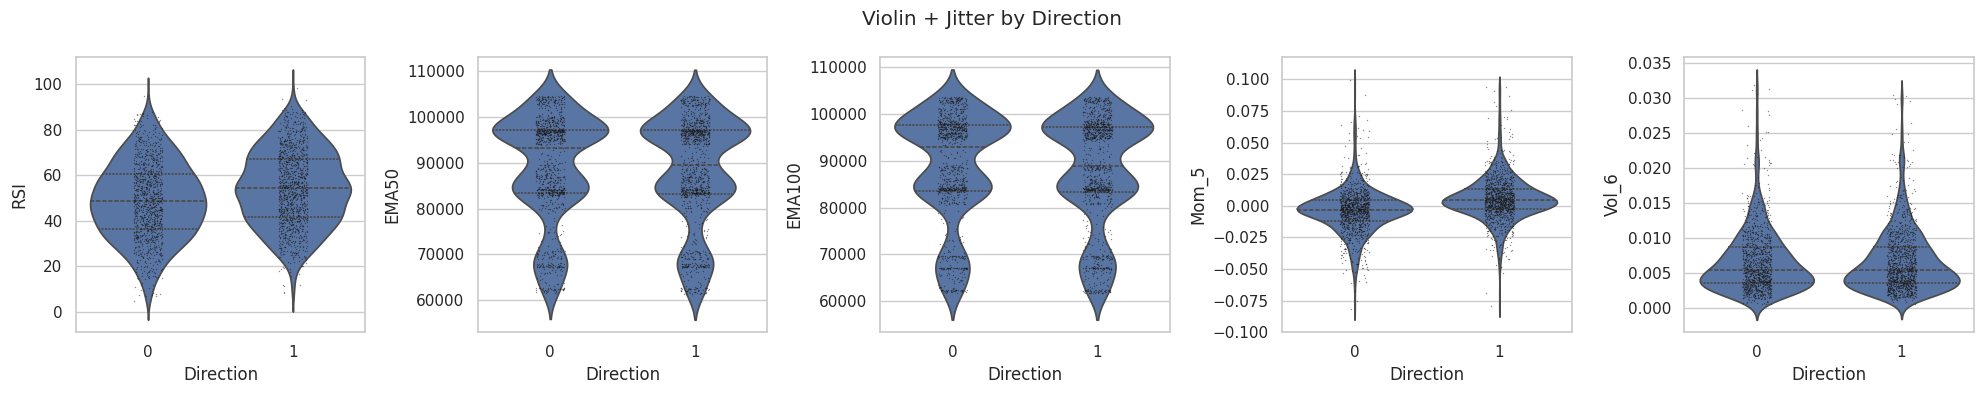

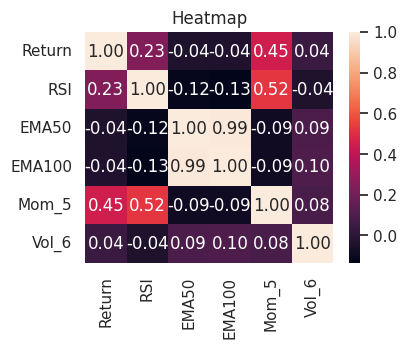

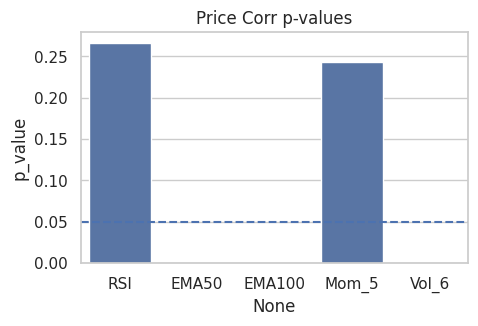

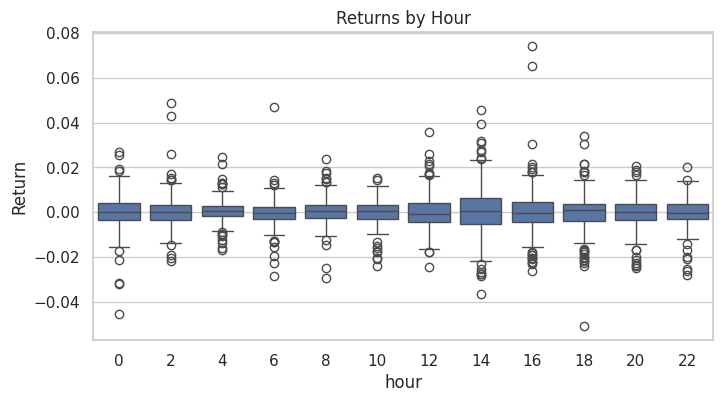

<Figure size 800x300 with 0 Axes>

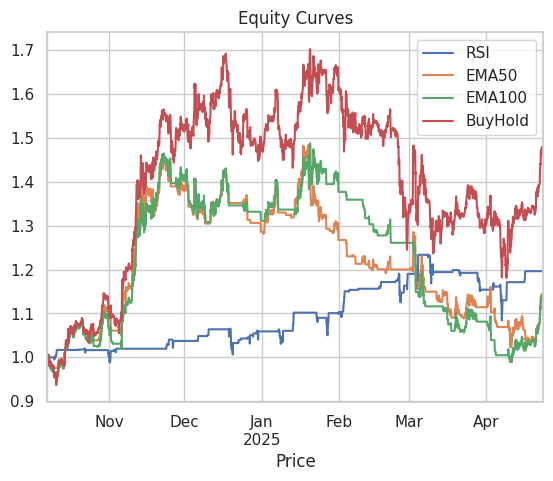

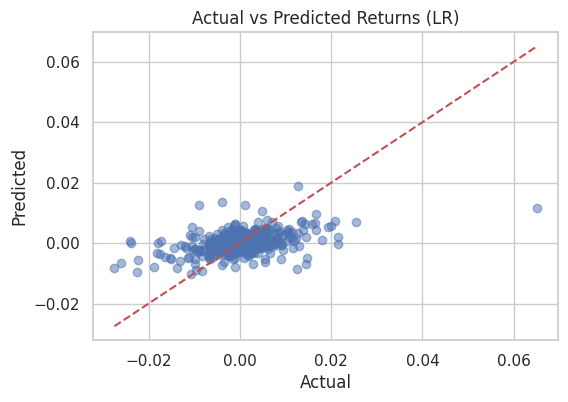

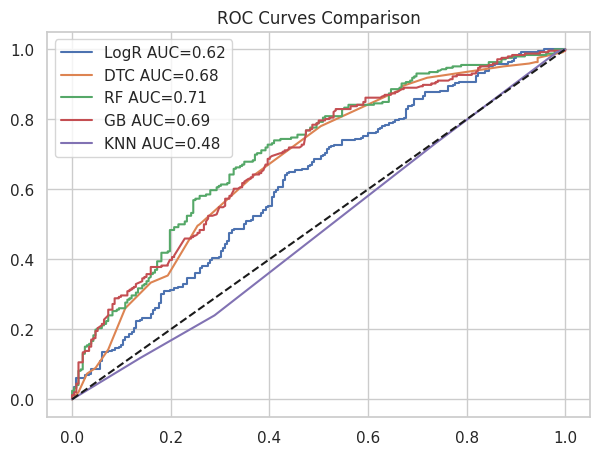

,Model,RMSE,MAE,Accuracy,AUC
0,LR,0.006682,0.004532,nan,nan
1,LogR,nan,nan,0.585774,0.617466
2,DTC,nan,nan,0.642259,0.675944
3,RF,nan,nan,0.648536,0.707930
4,GB,nan,nan,0.650628,0.690908
5,KNN,nan,nan,0.504184,0.481777


--- Timeframe: 3H ---
        Pearson_r
RSI      0.257076
EMA50   -0.047986
EMA100  -0.048384
Mom_5    0.441590
Vol_6    0.043510
OLS R-squared: 0.196
Logistic AUC: 0.670



<ipython-input-5-5e861faa18af>:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


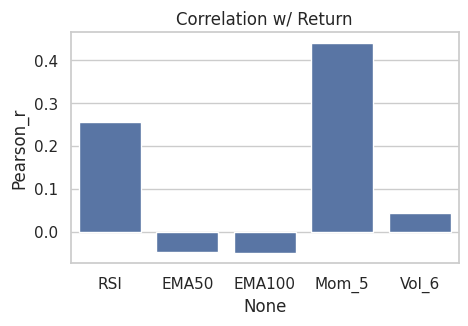

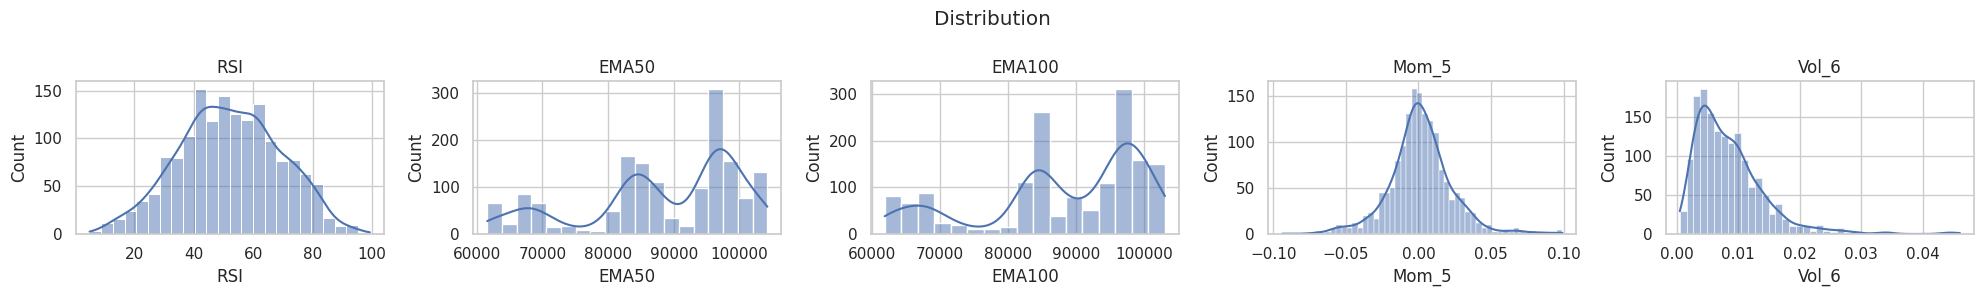

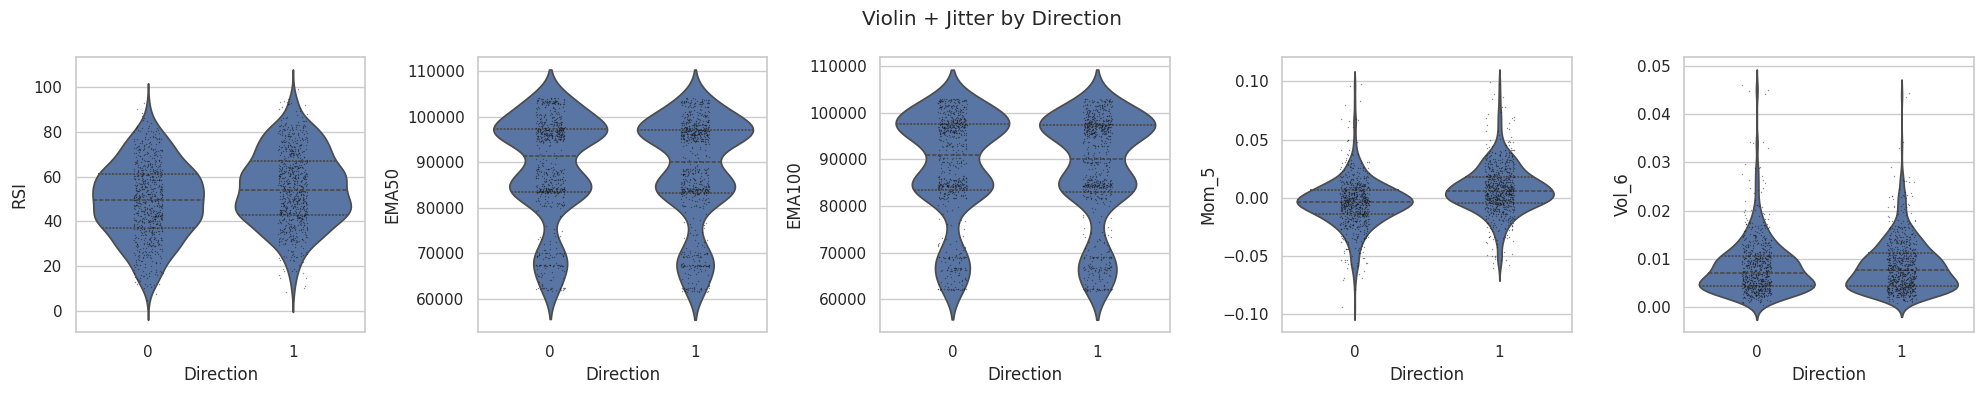

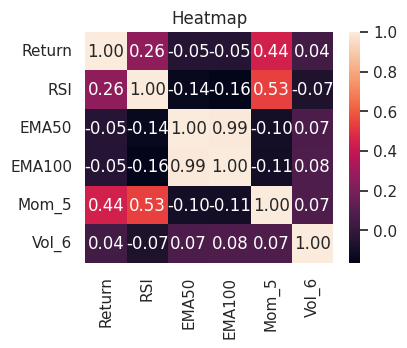

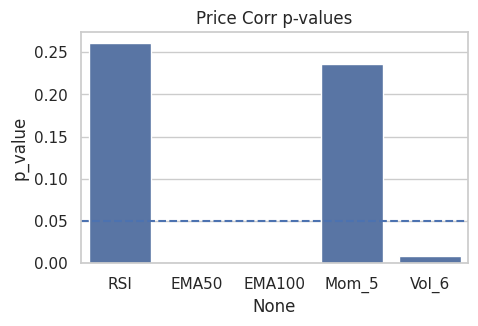

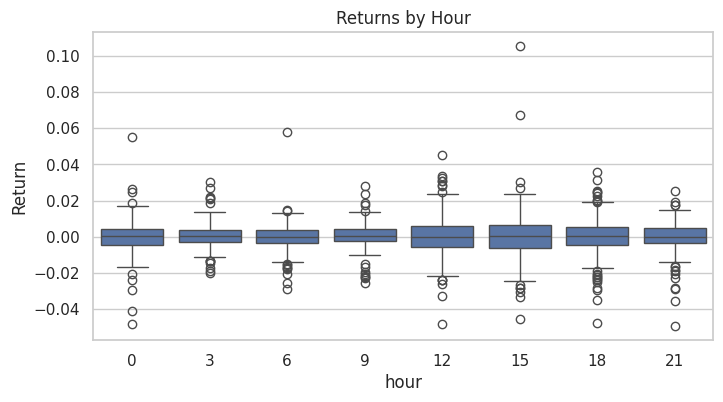

<Figure size 800x300 with 0 Axes>

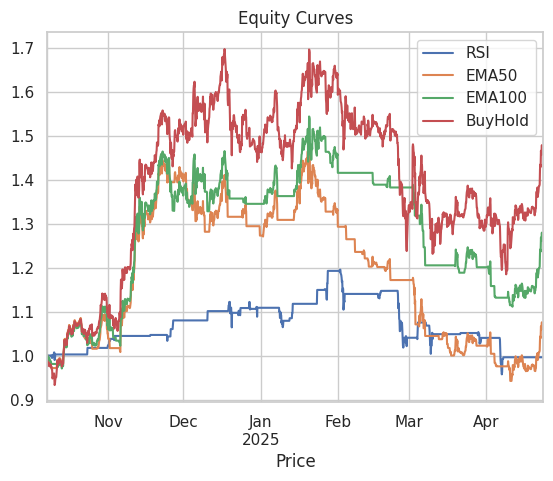

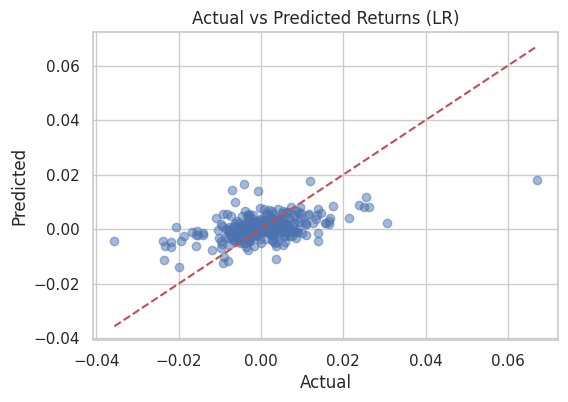

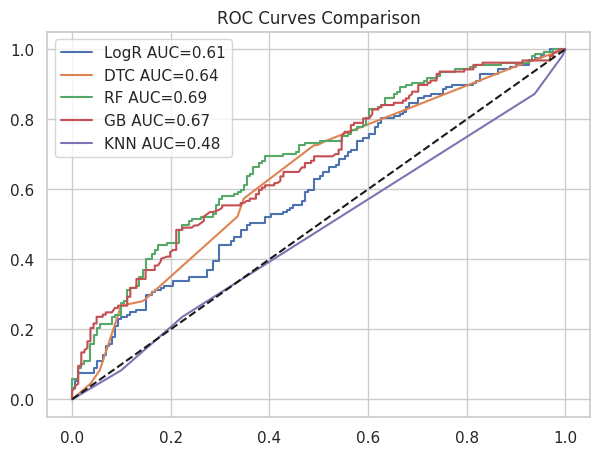

,Model,RMSE,MAE,Accuracy,AUC
0,LR,0.007878,0.005529,nan,nan
1,LogR,nan,nan,0.578616,0.607390
2,DTC,nan,nan,0.616352,0.639000
3,RF,nan,nan,0.641509,0.686711
4,GB,nan,nan,0.597484,0.670550
5,KNN,nan,nan,0.509434,0.477667


--- Timeframe: 4H ---
        Pearson_r
RSI      0.274704
EMA50   -0.059717
EMA100  -0.061119
Mom_5    0.440012
Vol_6    0.055245
OLS R-squared: 0.195
Logistic AUC: 0.642



<ipython-input-5-5e861faa18af>:221: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df_raw.resample(tf).last().dropna()


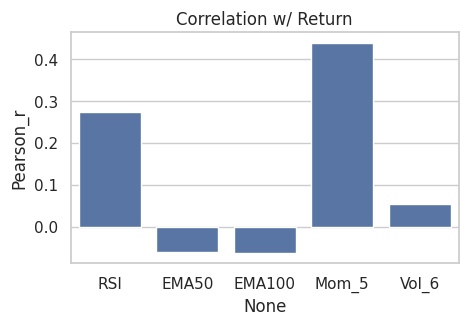

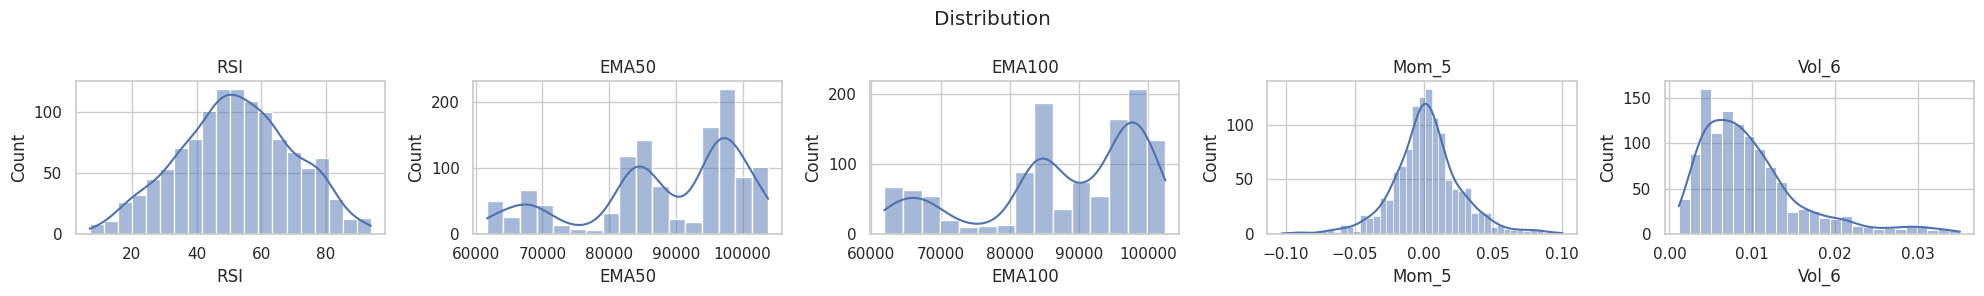

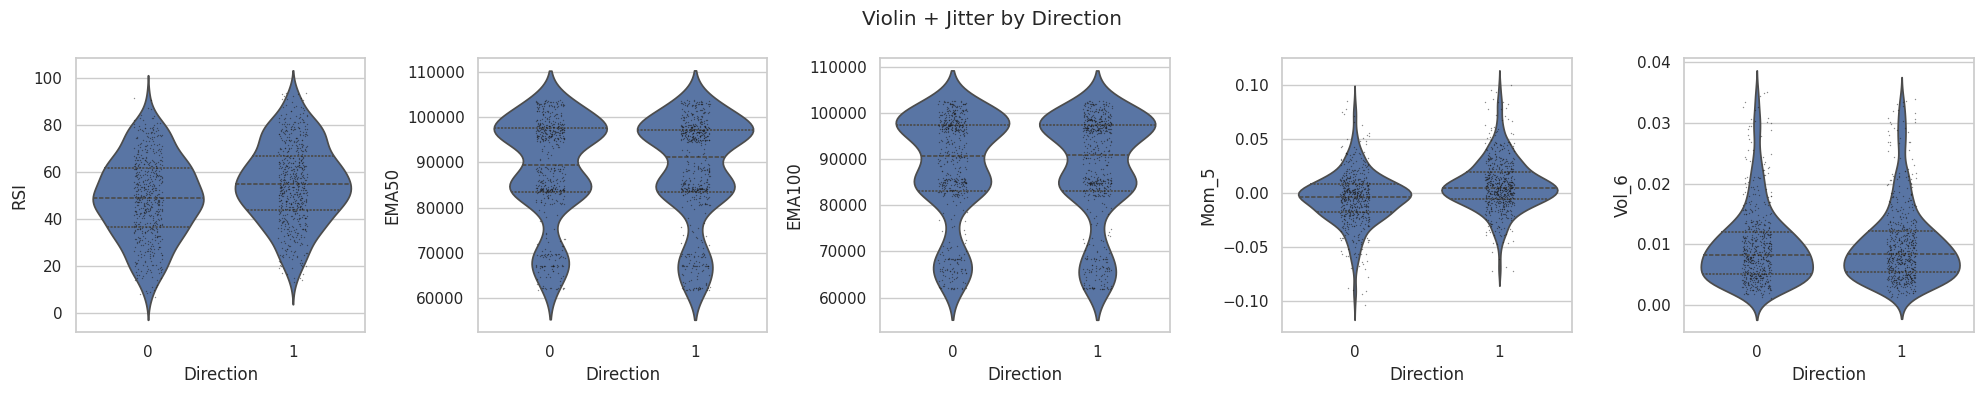

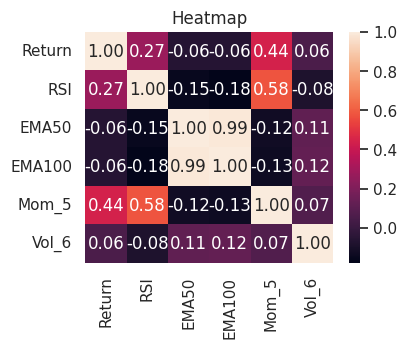

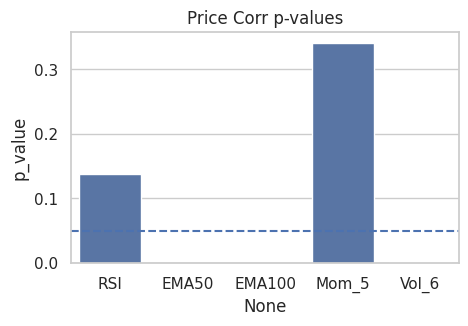

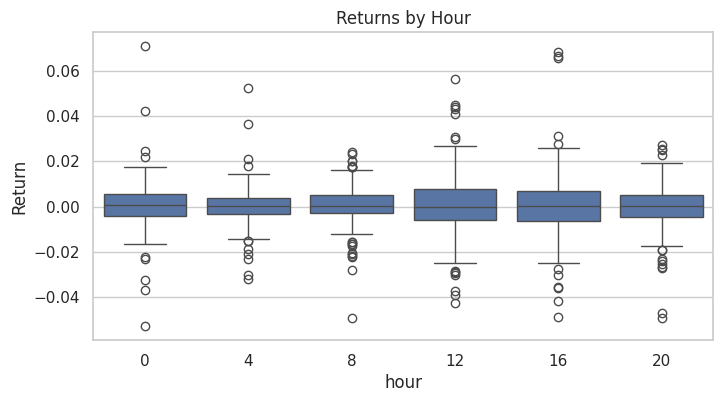

<Figure size 800x300 with 0 Axes>

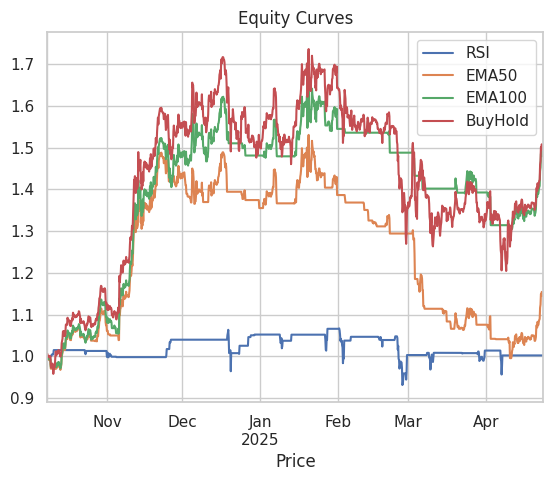

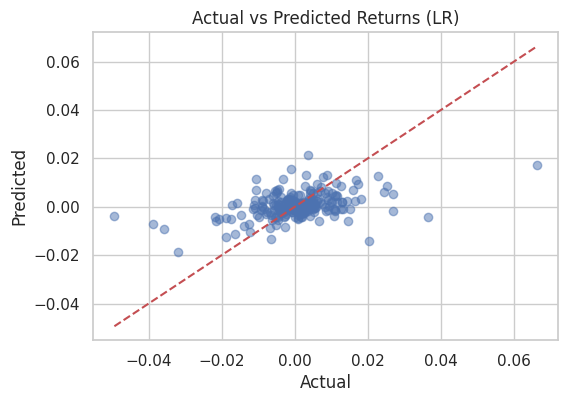

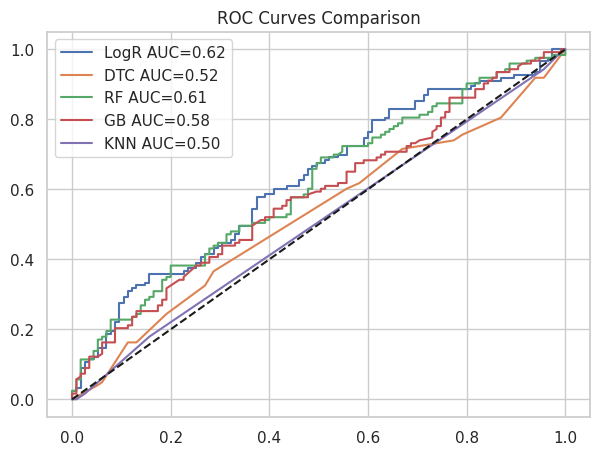

,Model,RMSE,MAE,Accuracy,AUC
0,LR,0.009810,0.006587,nan,nan
1,LogR,nan,nan,0.579832,0.624814
2,DTC,nan,nan,0.521008,0.522375
3,RF,nan,nan,0.554622,0.609650
4,GB,nan,nan,0.550420,0.580665
5,KNN,nan,nan,0.500000,0.503959


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.formula.api import ols, logit as sm_logit
from sklearn.metrics import (
    roc_auc_score, accuracy_score, mean_squared_error,
    mean_absolute_error, roc_curve
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display

sns.set(style="whitegrid")

# --- 1) Data loading and indicator calculation ---
def load_and_preprocess(fname, sheet='BTC_Hourly'):
    df = pd.read_excel(fname, sheet_name=sheet, skiprows=[1,2], index_col=0, engine='openpyxl')
    df.index = pd.to_datetime(df.index)
    df = df[['Close']].dropna()
    return df


def compute_indicators(df):
    df = df.copy()
    # EMAs
    df['EMA50']  = df['Close'].ewm(span=50, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    # RSI
    delta     = df['Close'].diff()
    gain      = delta.clip(lower=0)
    loss      = -delta.clip(upper=0)
    avg_gain  = gain.rolling(14).mean()
    avg_loss  = loss.rolling(14).mean()
    df['RSI'] = 100 - (100 / (1 + avg_gain / avg_loss))
    # Momentum & Volatility
    df['Mom_5'] = df['Close'].pct_change(5)
    df['Vol_6'] = df['Close'].pct_change().rolling(6).std()
    # Returns
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

# --- 2) Original analysis: stats, regressions, backtest & plots ---
def analyze(df):
    # Correlations with Return
    corr_vals = {col: pearsonr(df[col], df['Return'])[0] for col in ['RSI','EMA50','EMA100','Mom_5','Vol_6']}
    corr_df = pd.DataFrame.from_dict(corr_vals, orient='index', columns=['Pearson_r'])

    # Regression & classification (statsmodels)
    lm = ols('Return ~ RSI + EMA50 + EMA100 + Mom_5 + Vol_6', data=df).fit()
    df['Direction'] = (df['Return'] > 0).astype(int)
    logm = sm_logit('Direction ~ RSI + EMA50 + EMA100 + Mom_5 + Vol_6', data=df).fit(disp=False)
    logit_auc = roc_auc_score(df['Direction'], logm.predict(df))

    # Strategy signals and equity
    signals = pd.DataFrame({
        'RSI':    (df['RSI'] < 30).astype(int),
        'EMA50':  (df['Close'] > df['EMA50']).astype(int),
        'EMA100': (df['Close'] > df['EMA100']).astype(int)
    }).shift(1).fillna(0)
    strat = signals.multiply(df['Return'], axis=0)
    equity = (1 + strat).cumprod()
    equity['BuyHold'] = (1 + df['Return']).cumprod()

    # Correlation with Price significance
    sig = {}
    for col in ['RSI','EMA50','EMA100','Mom_5','Vol_6']:
        r, p = pearsonr(df[col], df['Close'])
        sig[col] = {'r': r, 'p_value': p}
    sig_df = pd.DataFrame(sig).T

    return corr_df, lm, logit_auc, strat, equity, sig_df


def ml_analysis(df):
    features = ['RSI','EMA50','EMA100','Mom_5','Vol_6']
    X = df[features]
    y_reg = df['Return']
    df['Direction'] = (df['Return'] > 0).astype(int)
    y_clf = df['Direction']

    split = int(len(df)*0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_reg_train, y_reg_test = y_reg.iloc[:split], y_reg.iloc[split:]
    y_clf_train, y_clf_test = y_clf.iloc[:split], y_clf.iloc[split:]

    # 1) Linear Regression
    lr = LinearRegression().fit(X_train, y_reg_train)
    y_pred_reg = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
    mae = mean_absolute_error(y_reg_test, y_pred_reg)

    # 2) Logistic Regression
    logr = LogisticRegression(max_iter=200).fit(X_train, y_clf_train)
    y_pr_log = logr.predict_proba(X_test)[:,1]
    acc_log = accuracy_score(y_clf_test, logr.predict(X_test))
    auc_log = roc_auc_score(y_clf_test, y_pr_log)

    # 3) Decision Tree
    dtc = DecisionTreeClassifier(max_depth=5).fit(X_train, y_clf_train)
    y_pr_dtc = dtc.predict_proba(X_test)[:,1]
    acc_dtc = accuracy_score(y_clf_test, dtc.predict(X_test))
    auc_dtc = roc_auc_score(y_clf_test, y_pr_dtc)

    # 4) Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42).fit(X_train, y_clf_train)
    y_pr_rf = rf.predict_proba(X_test)[:,1]
    acc_rf = accuracy_score(y_clf_test, rf.predict(X_test))
    auc_rf = roc_auc_score(y_clf_test, y_pr_rf)

    # 5) Gradient Boosting
    gbc = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_clf_train)
    y_pr_gbc = gbc.predict_proba(X_test)[:,1]
    acc_gbc = accuracy_score(y_clf_test, gbc.predict(X_test))
    auc_gbc = roc_auc_score(y_clf_test, y_pr_gbc)

    # 6) K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_clf_train)
    y_pr_knn = knn.predict_proba(X_test)[:,1]
    acc_knn = accuracy_score(y_clf_test, knn.predict(X_test))
    auc_knn = roc_auc_score(y_clf_test, y_pr_knn)

    # Regression plot
    plt.figure(figsize=(6,4))
    plt.scatter(y_reg_test, y_pred_reg, alpha=0.5)
    plt.plot([y_reg_test.min(), y_reg_test.max()],[y_reg_test.min(), y_reg_test.max()],'r--')
    plt.title('Actual vs Predicted Returns (LR)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # ROC Curves
    plt.figure(figsize=(7,5))
    for name, y_pr, aucv in [('LogR', y_pr_log, auc_log), ('DTC', y_pr_dtc, auc_dtc),
                             ('RF', y_pr_rf, auc_rf), ('GB', y_pr_gbc, auc_gbc),
                             ('KNN', y_pr_knn, auc_knn)]:
        fpr, tpr, _ = roc_curve(y_clf_test, y_pr)
        plt.plot(fpr, tpr, label=f'{name} AUC={aucv:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.show()

    # Metrics summary styled table
    data = {'Model': ['LR','LogR','DTC','RF','GB','KNN'],
            'RMSE': [rmse, np.nan, np.nan, np.nan, np.nan, np.nan],
            'MAE': [mae, np.nan, np.nan, np.nan, np.nan, np.nan],
            'Accuracy': [np.nan, acc_log, acc_dtc, acc_rf, acc_gbc, acc_knn],
            'AUC': [np.nan, auc_log, auc_dtc, auc_rf, auc_gbc, auc_knn]}
    metrics_df = pd.DataFrame(data)
    styled = metrics_df.style.background_gradient(cmap='Blues', axis=None)
    display(styled)
    return metrics_df

# --- 4) Plotting functions for original analyses ---
def plot_corr_bar(corr_df, title):
    plt.figure(figsize=(5,3))
    sns.barplot(x=corr_df.index, y='Pearson_r', data=corr_df.reset_index().rename(columns={'index':'Indicator'}))
    plt.title(title)
    plt.show()

def plot_histograms(df, cols, title):
    fig, axes = plt.subplots(1, len(cols), figsize=(4*len(cols),3))
    for ax, col in zip(axes, cols):
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(col)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_violin_scatter(df, cols, hue, title):
    fig, axes = plt.subplots(1, len(cols), figsize=(4*len(cols),4))
    for ax, col in zip(axes, cols):
        sns.violinplot(x=df[hue], y=df[col], ax=ax, inner='quartile')
        sns.stripplot(x=df[hue], y=df[col], ax=ax, color='k', size=1, alpha=0.5)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_corr_heatmap(df, cols, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(df[cols].corr(), annot=True, fmt='.2f')
    plt.title(title)
    plt.show()

def plot_price_corr_significance(sig_df, title, alpha=0.05):
    plt.figure(figsize=(5,3))
    sns.barplot(x=sig_df.index, y='p_value', data=sig_df.reset_index().rename(columns={'index':'Indicator'}))
    plt.axhline(alpha, linestyle='--')
    plt.title(title)
    plt.show()

def plot_returns_by_hour(df):
    df_ = df.copy()
    df_['hour'] = df_.index.hour
    plt.figure(figsize=(8,4))
    sns.boxplot(x='hour', y='Return', data=df_)
    plt.title('Returns by Hour')
    plt.show()

def plot_equity(equity, title):
    plt.figure(figsize=(8,3))
    equity.plot()
    plt.title(title)
    plt.show()

# --- 5) Main execution ---
if __name__ == '__main__':
    from google.colab import files
    uploaded = files.upload()
    fname = next(iter(uploaded.keys()))

    df_raw = load_and_preprocess(fname)
    timeframes = ['1H','2H','3H','4H']
    for tf in timeframes:
        print(f"--- Timeframe: {tf} ---")
        df_tf = df_raw.resample(tf).last().dropna()
        df_ind = compute_indicators(df_tf)

        # Original analyses
        corr_df, lm, logit_auc, strat, equity, sig_df = analyze(df_ind)
        print(corr_df)
        print(f"OLS R-squared: {lm.rsquared:.3f}")
        print(f"Logistic AUC: {logit_auc:.3f}\n")
        plot_corr_bar(corr_df, "Correlation w/ Return")
        plot_histograms(df_ind, ['RSI','EMA50','EMA100','Mom_5','Vol_6'], "Distribution")
        plot_violin_scatter(df_ind, ['RSI','EMA50','EMA100','Mom_5','Vol_6'], 'Direction', "Violin + Jitter by Direction")
        plot_corr_heatmap(df_ind, ['Return','RSI','EMA50','EMA100','Mom_5','Vol_6'], "Heatmap")
        plot_price_corr_significance(sig_df, "Price Corr p-values")
        plot_returns_by_hour(df_ind)
        plot_equity(equity, "Equity Curves")


        ml_analysis(df_ind)
